In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from skimage.io import imread
from numpy.fft import fft2, fftshift
from scipy.signal import find_peaks
import glob
import os

In [2]:
def compute_calibration_2dfft(image_path: str,
                              true_period_um: float,
                              n_tiles: int = 4):
    """
    Compute µm/px calibration from a grating image using 2D FFT.
    """
    img = imread(image_path, as_gray=True).astype(float)
    h, w = img.shape

    img_d = img - img.mean()
    wy = np.hanning(h)[:,None]
    wx = np.hanning(w)[None,:]
    window2d = wy * wx
    proc = img_d * window2d

    F = fftshift(fft2(proc))
    mag = np.abs(F)
    cy, cx = h//2, w//2
    mag[cy, cx] = 0

    idx = np.unravel_index(np.argmax(mag), mag.shape)
    dy = (idx[0] - cy) / h
    dx = (idx[1] - cx) / w
    f = np.hypot(dy, dx)
    period_px = 1.0 / f

    # Tiled uncertainty
    tile_h = h // n_tiles
    tile_w = w // n_tiles
    periods = []
    for i in range(n_tiles):
        for j in range(n_tiles):
            tile = img_d[i*tile_h:(i+1)*tile_h, j*tile_w:(j+1)*tile_w]
            if tile.size < 4:
                continue
            thr = tile - tile.mean()
            twy = np.hanning(tile.shape[0])[:,None]
            twx = np.hanning(tile.shape[1])[None,:]
            tproc = thr * (twy * twx)
            Ft = fftshift(fft2(tproc))
            magt = np.abs(Ft)
            mh, mw = magt.shape
            magt[mh//2, mw//2] = 0
            midy, midx = mh//2, mw//2
            idt = np.unravel_index(np.argmax(magt), magt.shape)
            dy_t = (idt[0] - midy) / mh
            dx_t = (idt[1] - midx) / mw
            f_t = np.hypot(dy_t, dx_t)
            periods.append(1.0 / f_t)
    periods = np.array(periods)
    err_period = periods.std(ddof=1) if periods.size>1 else 0.0

    um_per_px = true_period_um / period_px
    um_per_px_err = true_period_um * err_period / (period_px**2)

    return um_per_px, um_per_px_err, idx, period_px, periods


In [3]:
def detect_stripes(img, polarity="bright", prominence=20, min_distance=40, plot=False):
    prof = img.mean(axis=0)
    if polarity.lower() == "dark":
        prof = -prof    # dark stripes become “peaks” in –profile
    peaks, props = find_peaks(prof, prominence=prominence, distance=min_distance)
    if plot:
        plt.figure(figsize=(10,3))
        plt.plot(prof, label="projection")
        plt.scatter(peaks, prof[peaks], c="r")
        plt.legend()
        plt.show()
    return peaks


In [4]:
def measure_stripe_widths(img, x_center, calibration_um_per_px,
                          n_scans=10, scan_spacing=100, window="all",
                          min_width_um=2, max_width_um=120, do_plot=False, save_path=None):
    """
    Measure the width of a stripe/bar at multiple heights using edge detection.
    """
    h, w = img.shape
    start_y = h  # Start at the bottom and move up
    widths = []

    if do_plot:
        fig = plt.figure(figsize=(8,5))
        gs = fig.add_gridspec(1,2)
        cmap = plt.get_cmap("viridis",n_scans)

    for i in range(n_scans):
        y = int(start_y - i*scan_spacing)-1  # From bottom up
        
        if window == "all":
            left = 0
            right = w
        else:    
            left = max(x_center - window, 0)
            right = min(x_center + window, w)

        profile = img[y, left:right]
        profile_smooth = cv2.GaussianBlur(profile[None, :], (9, 1), 0).flatten()
        edges, _ = find_peaks(-profile_smooth, prominence=15, distance=10)
        if len(edges) >= 2:
            width_px = np.abs(edges[-1] - edges[0])
            width_um = width_px * calibration_um_per_px
            widths.append(width_um)
        else:
            widths.append(np.nan)
            print("Not enough edges found")
            
        if do_plot:
            if i == 0:
                ax_img = fig.add_subplot(gs[0,0])
                ax_profile = fig.add_subplot(gs[0,1])
                ax_img.imshow(img)
            ax_img.axhline(y, color=cmap(i))
            ax_profile.plot(profile_smooth, color = cmap(i))
            ax_profile.scatter(edges, profile_smooth[edges], color='red')
            if i == n_scans-1:
                ax_profile.set_title(f"Avg. width={np.nanmean(widths):.2f} ± {np.nanstd(widths):.2f} µm")
            plt.show()

         # finalize & save/close
        if do_plot:
            mean_w = np.nanmean(widths)
            std_w  = np.nanstd(widths)
            ax_profile.set_title(f"Avg = {mean_w:.2f} ± {std_w:.2f} µm")
            plt.tight_layout()
            if save_path:
                fig.savefig(save_path, dpi=300, bbox_inches='tight')
                print(f"Saved plot to {save_path}")
            plt.close(fig)  

    widths = np.array(widths)
    good = widths[(widths >= min_width_um) & (widths <= max_width_um) & np.isfinite(widths)]
    return good, widths


In [5]:
# Set up data paths
stripes_50x_dir  = '../data/images/50x/'
cal_dir          = '../data/images/calibration'

# Gather all file paths
stripe_paths_50x = sorted(glob.glob(f'{stripes_50x_dir}/*.jpg'))
cal_paths        = sorted(glob.glob(f'{cal_dir}/*.jpg'))

print(f"Found {len(stripe_paths_50x)} high-mag stripes")
print(f"Found {len(cal_paths)} calibration images")

# Map filename tokens to true period (µm)
period_map = {
    '100Lpmm': 10    # 1/100 mm = 10 µm per line pair
}

um_px = []
for path in cal_paths:
    key = next((k for k in period_map if k in path), None)
    if key is None:
        print(f"Skipping unknown: {path}")
        continue
    true_um = period_map[key]
    this_um_px, err, peak_idx, ppx, periods = compute_calibration_2dfft(path, true_um, n_tiles=2)
    fname = path.split('/')[-1]
    print(f"{fname:20s} | µm/px = {this_um_px:.4f} ± {err:.4f} | peak @ {peak_idx} | period ≈ {ppx:.1f}px")
    um_px.append(this_um_px)

calibration_um_per_px = um_px[0]  # Use first calibration (50x)


Found 14 high-mag stripes
Found 2 calibration images
100Lpmm_50x.jpg      | µm/px = 0.0651 ± 0.0000 | peak @ (758, 1024) | period ≈ 153.6px
Skipping unknown: ../data/images/calibration/25Lpmm_3p2x.jpg


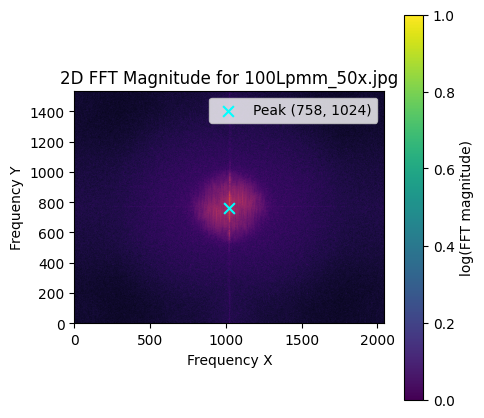

In [6]:
cal_path = "../data/images/calibration/100Lpmm_50x.jpg"
# Title = filename
title = cal_path.split('/')[-1]

# Load & preprocess
img = imread(cal_path, as_gray=True).astype(float)
h, w = img.shape
img_d = img - img.mean()

# Build 2D Hann window (same as compute_calibration_2dfft)
wy = np.hanning(h)[:, None]
wx = np.hanning(w)[None, :]
window2d = wy * wx
proc = img_d * window2d

# 2D FFT
F = fftshift(fft2(proc))
mag = np.abs(F)

# Zero out DC
cy, cx = h//2, w//2
mag[cy, cx] = 0

# Find peak
peak = np.unravel_index(np.argmax(mag), mag.shape)

# Plot
plt.figure(figsize=(5,5))
plt.imshow(np.log1p(mag), origin='lower', cmap='inferno')
plt.scatter(peak[1], peak[0], c='cyan', s=60, marker='x', label=f'Peak {peak}')
plt.title(f'2D FFT Magnitude for {title}')
plt.xlabel('Frequency X')
plt.ylabel('Frequency Y')
plt.legend(loc='upper right')
plt.colorbar(label='log(FFT magnitude)')
file_name = '100Lpmm_50x_fft_cal.png'
folder_path = '../results/figures/'
file_path = os.path.join(folder_path, file_name)
plt.savefig(file_path)
plt.show()

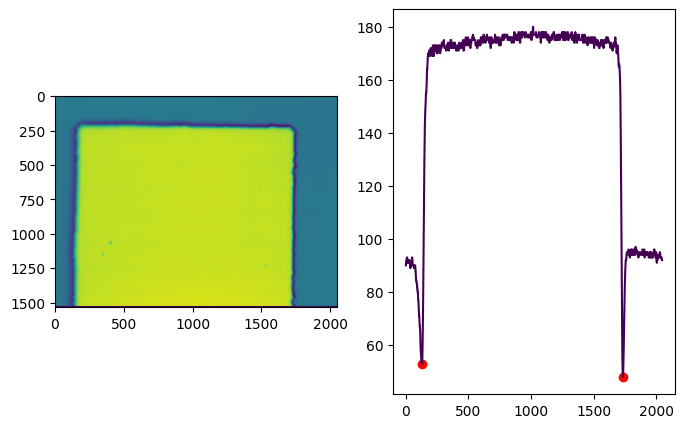

Saved plot to ../results/figures/new/40sec_ln01_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln01_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln01_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln01_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln01_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln01_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln01_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln01_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln01_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln01_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

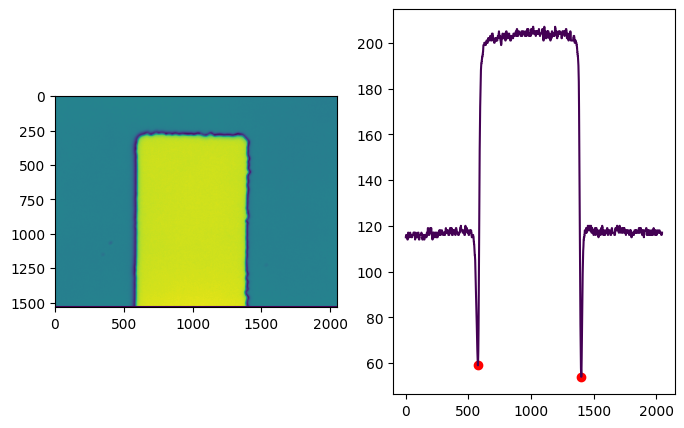

Saved plot to ../results/figures/new/40sec_ln02_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln02_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln02_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln02_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln02_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln02_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln02_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln02_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln02_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln02_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

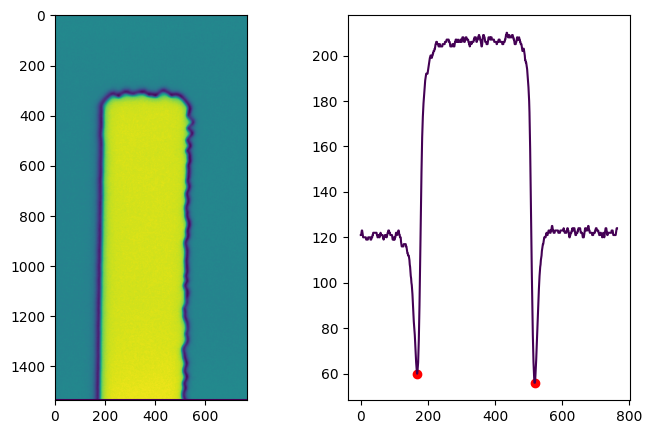

Saved plot to ../results/figures/new/40sec_ln03_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln03_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln03_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln03_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln03_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln03_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln03_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln03_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln03_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln03_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

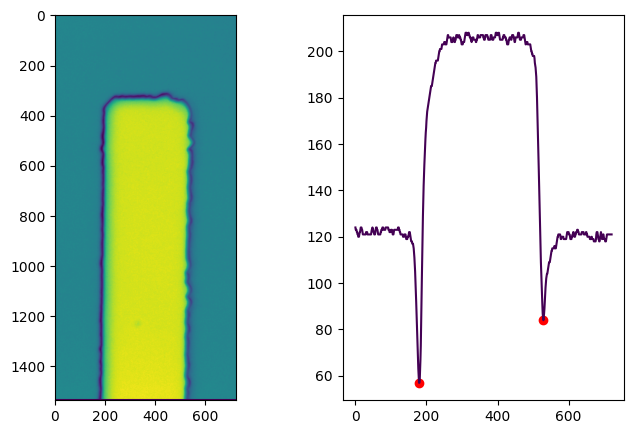

Saved plot to ../results/figures/new/40sec_ln04_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln04_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln04_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln04_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln04_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln04_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln04_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln04_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln04_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln04_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

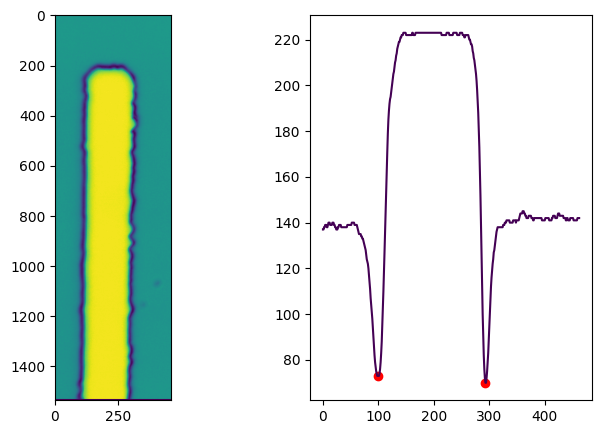

Saved plot to ../results/figures/new/40sec_ln05_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln05_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln05_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln05_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln05_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln05_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln05_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln05_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln05_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln05_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

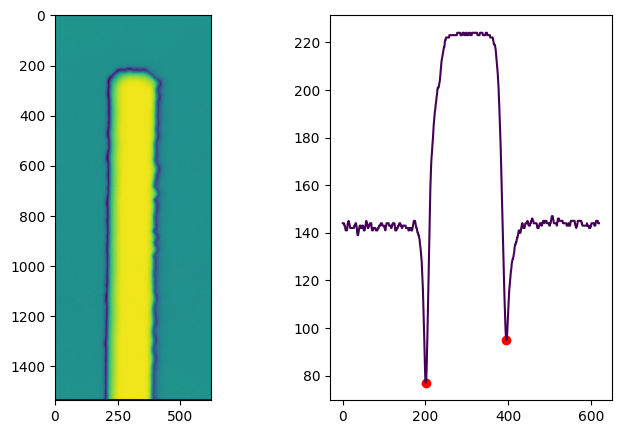

Saved plot to ../results/figures/new/40sec_ln06_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln06_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln06_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln06_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln06_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln06_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln06_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln06_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln06_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln06_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

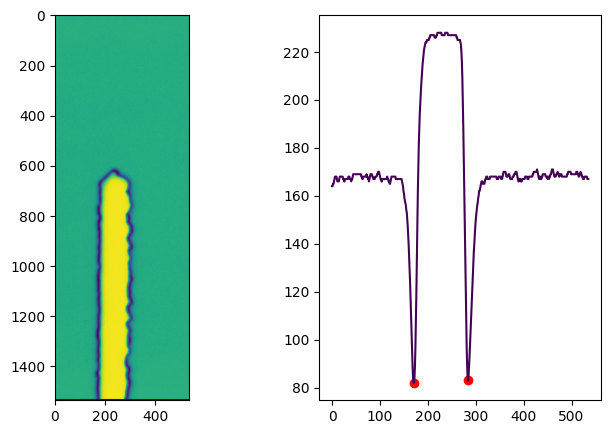

Saved plot to ../results/figures/new/40sec_ln07_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln07_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln07_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln07_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln07_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln07_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln07_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln07_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln07_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln07_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

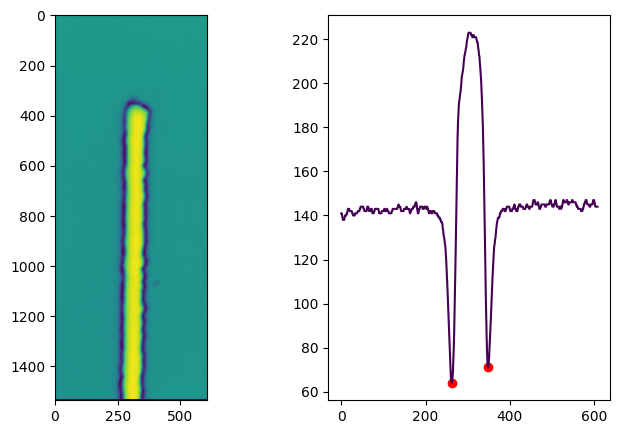

Saved plot to ../results/figures/new/40sec_ln08_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln08_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln08_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln08_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln08_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln08_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln08_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln08_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln08_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln08_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

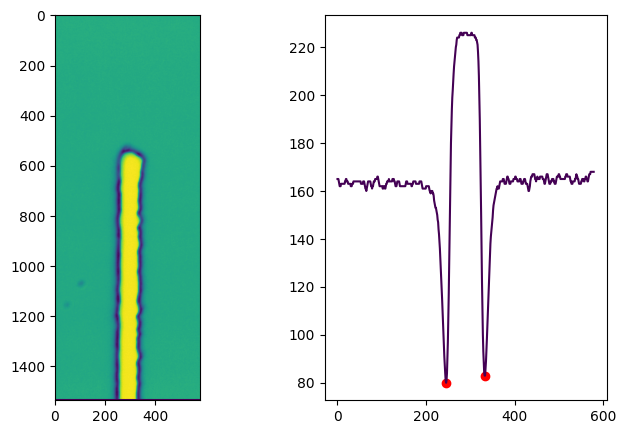

Saved plot to ../results/figures/new/40sec_ln09_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln09_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln09_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln09_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln09_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln09_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln09_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln09_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln09_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln09_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

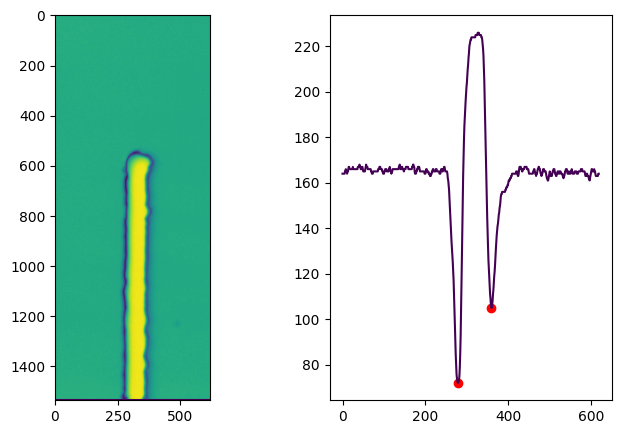

Saved plot to ../results/figures/new/40sec_ln10_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln10_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln10_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln10_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln10_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln10_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln10_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln10_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln10_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln10_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

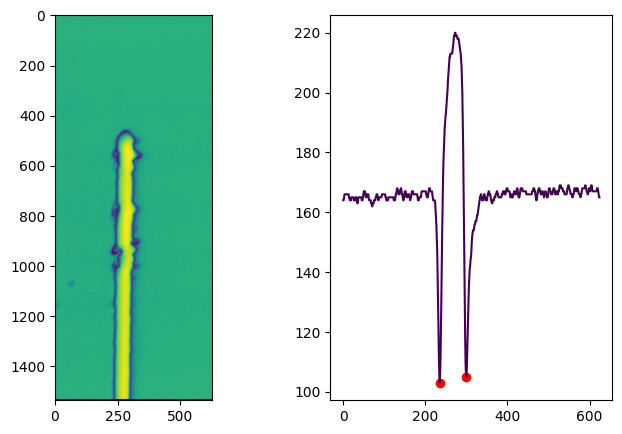

Saved plot to ../results/figures/new/40sec_ln11_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln11_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln11_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln11_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln11_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln11_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln11_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln11_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln11_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln11_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

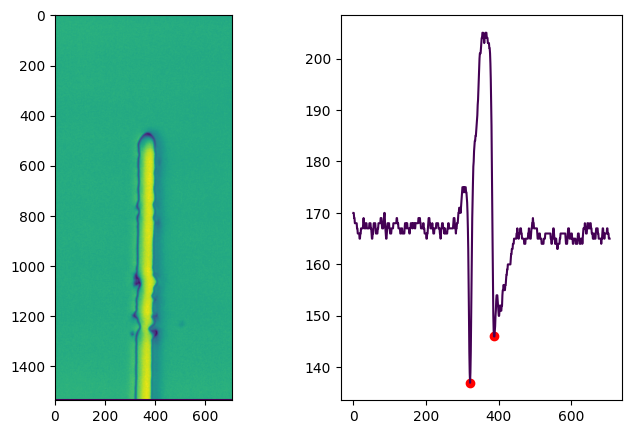

Saved plot to ../results/figures/new/40sec_ln12_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln12_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln12_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln12_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln12_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln12_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln12_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln12_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln12_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln12_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

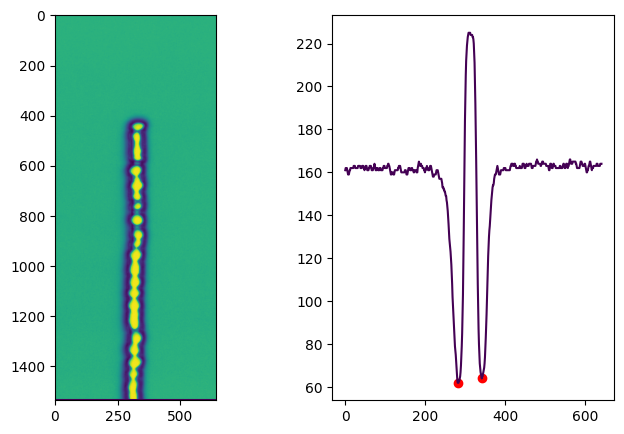

Saved plot to ../results/figures/new/40sec_ln13_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln13_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln13_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln13_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln13_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln13_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln13_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln13_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln13_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln13_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

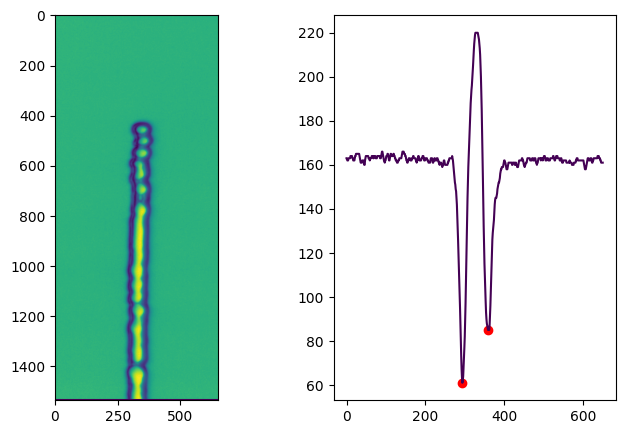

Saved plot to ../results/figures/new/40sec_ln14_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln14_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln14_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln14_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln14_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln14_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln14_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln14_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln14_50x_stripe01.png


<Figure size 640x480 with 0 Axes>

Saved plot to ../results/figures/new/40sec_ln14_50x_stripe01.png
Saved stripe measurements to ../results/tables/stripe_measurements.csv


<Figure size 640x480 with 0 Axes>

In [7]:
all_results = []
scan_spacing_px = 100
window  = "all"
plots_dir = "../results/figures/new/"

for fname in sorted(os.listdir(stripes_50x_dir)):
    if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue
    path = os.path.join(stripes_50x_dir, fname)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Could not read {path}")
        continue
    stripe_centers = detect_stripes(img)
    for i, x_center in enumerate(stripe_centers, start=1):
        save_fn = f"{os.path.splitext(fname)[0]}_stripe{i:02d}.png"
        save_path = os.path.join(plots_dir, save_fn)
        widths_um, all_widths_um = measure_stripe_widths(
            img, x_center, calibration_um_per_px,
            n_scans=10, scan_spacing=scan_spacing_px, window=window,
            min_width_um=2, max_width_um=120, do_plot=True, save_path=save_path
        )
        if len(widths_um) > 0:
            all_results.append({
                "image": fname,
                "stripe_num": i+1,
                "x_center_px": x_center,
                "n_valid_scans": len(widths_um),
                "mean_width_um": np.mean(widths_um),
                "std_width_um": np.std(widths_um),
                "all_widths_um": widths_um.tolist()
            })
df_stripes = pd.DataFrame(all_results)
df_sorted = df_stripes.sort_values('mean_width_um', ascending=False).reset_index(drop=True)
csv_path = "../results/tables/stripe_measurements.csv"
df_sorted.to_csv(csv_path, index=False)
print(f"Saved stripe measurements to {csv_path}")

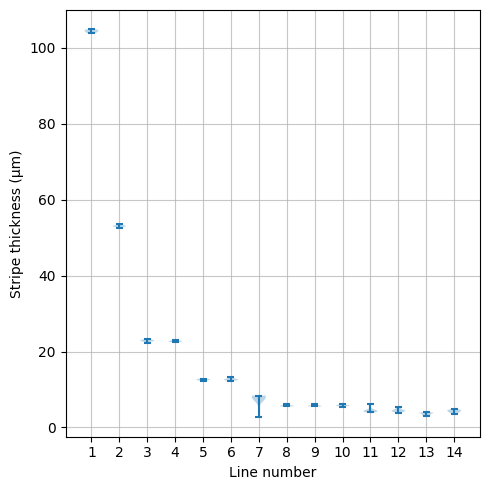

In [8]:
# Flatten all widths by objective
all_widths_50x = np.concatenate(df_stripes['all_widths_um'].values)

fig_stat = plt.figure(figsize=(5, 5), layout="tight")
ax_stat = fig_stat.add_subplot(111)
ax_stat.violinplot(df_stripes.all_widths_um)
ax_stat.grid(alpha=0.7)
ax_stat.set_ylabel("Stripe thickness (µm)")
ax_stat.set_xlabel("Line number")
ax_stat.xaxis.set_major_locator(MultipleLocator(1))
file_name = 'stripe_summary.png'
folder_path = '../results/figures/new/'
file_path = os.path.join(folder_path, file_name)
plt.savefig(file_path)
plt.show()


Saved mask data to ../results/tables/mask_measurements_50x.csv
Saved comparison data to ../results/tables/real_vs_mask_comparison_50x.csv
    line     real_um   mask_um
0      1  104.420573  101.1003
1      3   22.864583   20.9622
2      4   22.753906   20.5716
3      5   12.610677   10.9368
4      6   12.714844   11.2623
5      7    7.513021    5.8590
6      8    5.748698    6.3798
7      9    5.729167    4.4268
8      9    5.729167    4.2315
9     10    5.774740    3.6456
10    10    5.774740    3.5805
11    11    4.479167    3.4503
12    12    4.466146    2.9946
13    13    3.632812    2.0181
14    14    4.231771    1.8879


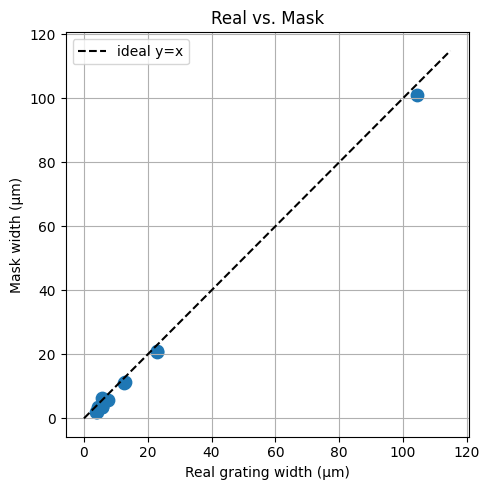

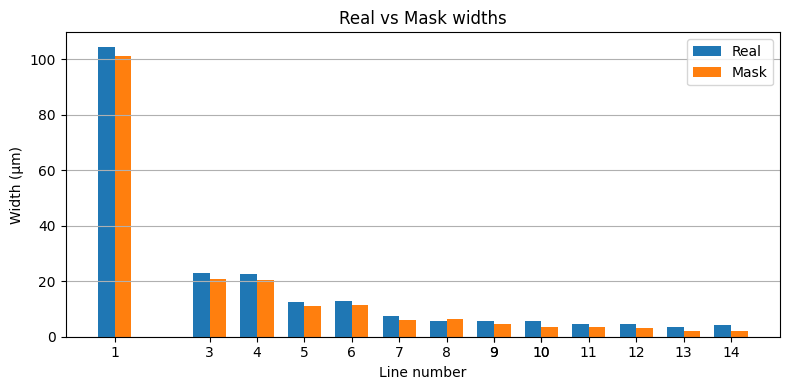

In [9]:
import re
from scipy.ndimage import binary_fill_holes, label

UM_PER_PX = 0.0651

# extract line numbers from a mask filename ———
def parse_mask_lines(fn):
    # find the digits after "Linie" before the dot
    m = re.search(r'Linie([\d ]+)\.', fn)
    s = m.group(1).strip()
    if ' ' in s:
        toks = s.split()
    else:
        # e.g. "080910" → ["08","09","10"]
        toks = [s[i:i+2] for i in range(0, len(s), 2)]
    return [int(tok.lstrip('0') or '0') for tok in toks]

# LOAD your real‐grating results 
df_real = df_stripes.copy()
# pull out the line index from names like "c_ln03_50x.jpg"
df_real['line'] = df_real['image'].str.extract(r'ln0*([1-9]\d*)').astype(int)
df_real = df_real[['line','mean_width_um']].rename(columns={'mean_width_um':'real_um'})

# PROCESS ALL MASKS
mask_dir = "../data/images/masks/50x/"
records = []

for fn in sorted(os.listdir(mask_dir)):
    if not fn.lower().endswith(('.jpg','.png')):
        continue
    img8 = cv2.imread(os.path.join(mask_dir,fn), cv2.IMREAD_GRAYSCALE)
    if img8 is None:
        continue

    # invert so lines → white
    inv = img8.max() - img8

    # Otsu threshold + hole fill
    _, thr = cv2.threshold(inv, 0, 255,
                           cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    bw = binary_fill_holes(thr>0)

    # label connected components
    lbl, n = label(bw)

    # pull out each bar’s width in px
    line_numbers = parse_mask_lines(fn)
    for comp in range(1, n+1):
        ys, xs = np.where(lbl==comp)
        if xs.size==0:
            continue
        wpx = xs.max() - xs.min() + 1
        # skip tiny specks
        if wpx < 10:
            continue
        # map component index → the corresponding line number
        idx = comp-1
        if idx < len(line_numbers):
            line = line_numbers[idx]
        else:
            line = None

        records.append({
            'image':      fn,
            'stripe_idx': comp,
            'line':       line,
            'width_px':   wpx,
            'mask_um':    wpx * UM_PER_PX
        })

df_masks = pd.DataFrame(records).dropna(subset=['line'])
df_masks = df_masks.sort_values(['line','stripe_idx']).reset_index(drop=True)

# MERGE & COMPARE 
df_cmp = pd.merge(df_real, df_masks[['line','mask_um']],
                  on='line').sort_values('line')

output_dir = '../results/tables/'
# Mask measurements
masks_csv = os.path.join(output_dir, "mask_measurements_50x.csv")
df_masks.to_csv(masks_csv, index=False)
print(f"Saved mask data to {masks_csv}")

# Merged comparison
cmp_csv = os.path.join(output_dir, "real_vs_mask_comparison_50x.csv")
df_cmp.to_csv(cmp_csv, index=False)
print(f"Saved comparison data to {cmp_csv}")


# quick diagnostics
print(df_cmp)

# PLOT 
plt.figure(figsize=(5,5))
plt.scatter(df_cmp['real_um'], df_cmp['mask_um'], s=80)
lims = [0, df_cmp[['real_um','mask_um']].max().max()*1.1]
plt.plot(lims, lims, 'k--', label='ideal y=x')
plt.xlabel('Real grating width (µm)')
plt.ylabel('Mask width (µm)')
plt.title('Real vs. Mask')
plt.legend()
plt.grid(True)
file_name = 'real_vs_mask_scatter.png'
folder_path = '../results/figures/mask/'
file_path = os.path.join(folder_path, file_name)
plt.tight_layout()
plt.savefig(file_path)

plt.figure(figsize=(8,4))
x = df_cmp['line'].astype(int)
w = 0.35
plt.bar(x-w/2, df_cmp['real_um'], width=w, label='Real')
plt.bar(x+w/2, df_cmp['mask_um'], width=w, label='Mask')
plt.xlabel('Line number')
plt.ylabel('Width (µm)')
plt.title('Real vs Mask widths')
plt.xticks(x)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
file_name = 'real_vs_mask_bar.png'
file_path = os.path.join(folder_path, file_name)
plt.savefig(file_path)

plt.show()


In [11]:
df_masks

,image,stripe_idx,line,width_px,mask_um
0,50x_Linie002.jpg,1,0.0,796,51.8196
1,50x_Linie1.jpg,1,1.0,1553,101.1003
2,50x_Linie003 4.jpg,1,3.0,322,20.9622
3,50x_Linie003 4.jpg,2,4.0,316,20.5716
4,50x_Linie5 6 7.jpg,1,5.0,168,10.9368
5,50x_Linie5 6 7.jpg,2,6.0,173,11.2623
6,50x_Linie5 6 7.jpg,3,7.0,90,5.8590
7,50x_Linie080910.jpg,1,8.0,98,6.3798
8,50x_Linie091011.jpg,1,9.0,68,4.4268
9,50x_Linie080910.jpg,2,9.0,65,4.2315


In [13]:
# --- Calibration for 3.2× ---
cal_dir = '../data/images/calibration/'
cal_paths = glob.glob(os.path.join(cal_dir, '*25Lpmm*.jpg'))

if not cal_paths:
    raise FileNotFoundError("No 25Lpmm calibration image found in calibration directory.")

# True period for 25 Lp/mm = 40 µm
true_um = 40.0

um_px_list = []
for path in cal_paths:
    fname = os.path.basename(path)
    um_px, err_um_px, peak_idx, period_px, tile_periods = compute_calibration_2dfft(path, true_um, n_tiles=4)
    print(f"{fname:25s} → µm/px = {um_px:.5f} ± {err_um_px:.5f}, peak idx = {peak_idx}, period ≈ {period_px:.1f}px")
    um_px_list.append(um_px)

# Use the first calibration result
calibration_3p2x = um_px_list[0]
print(f"\nFinal 3.2× calibration factor: {calibration_3p2x:.5f} µm/px")

25Lpmm_3p2x.jpg           → µm/px = 1.01562 ± 0.00000, peak idx = (729, 1024), period ≈ 39.4px

Final 3.2× calibration factor: 1.01562 µm/px


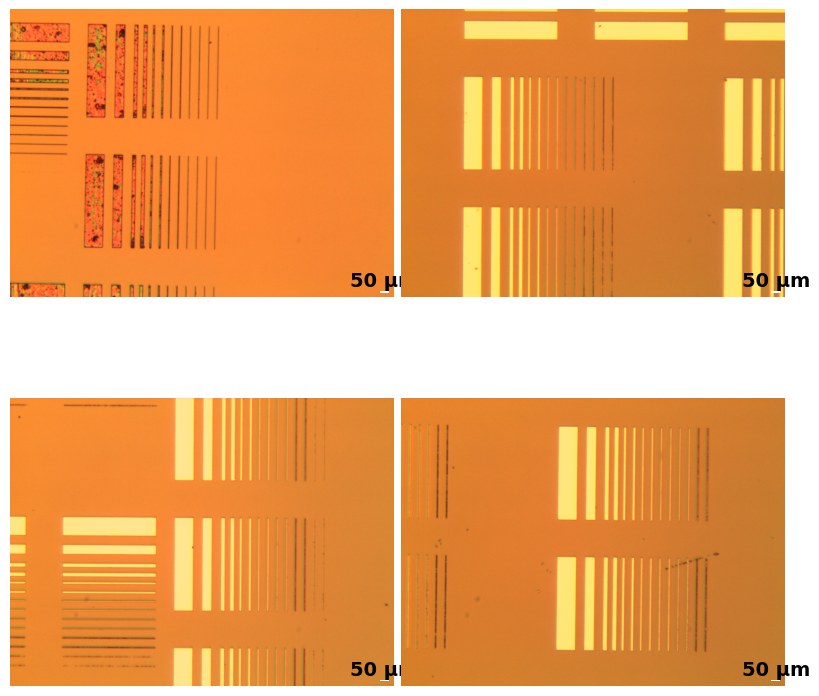

Composite saved to: ../results/figures/scalebars/composite_2x2_scalebar.png


In [27]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

SOURCE_DIR = '../data/images/stripes/3p2x'
OUT_DIR    = '../results/figures/scalebars'
UM_PER_PX  = 1.01562
BAR_UM     = 50
BAR_COLOR  = 'white'
TXT_COLOR  = 'black'
FONT_SIZE  = 14
FIGSIZE    = (10,10)
DPI        = 300

os.makedirs(OUT_DIR, exist_ok=True)

# sort by the “Nsec” in the filename
pattern = re.compile(r'(\d+)\s*sec')
files = sorted(
    glob.glob(os.path.join(SOURCE_DIR, '*sec_3p2x.jpg')),
    key=lambda p: int(pattern.search(os.path.basename(p)).group(1))
)

def add_scalebar(ax, um_per_px, length_um=BAR_UM,
                 pad_px=25, bar_thickness_px=6):
    """Place a white 50µm bar + black label in true bottom-right."""
    length_px = int(round(length_um / um_per_px))
    x0, x1 = ax.get_xlim();  y0, y1 = ax.get_ylim()
    ymin, ymax = sorted((y0, y1))

    xb = x1 - pad_px - length_px
    yb = ymax - pad_px - bar_thickness_px

    ax.add_patch(Rectangle((xb, yb), length_px, bar_thickness_px,
                           facecolor=BAR_COLOR, edgecolor='none',
                           transform=ax.transData, clip_on=False))

    tx = xb + length_px/2
    ty = yb - bar_thickness_px*0.8
    ax.text(tx, ty, f'{length_um:g} µm',
            color=TXT_COLOR, ha='center', va='bottom',
            fontsize=FONT_SIZE, fontweight='bold',
            transform=ax.transData, clip_on=False)

# ─── BUILD & SAVE 2×2 PANEL ─────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=FIGSIZE)
axes = axes.flatten()

for ax, fp in zip(axes, files):
    img = np.asarray(Image.open(fp))
    ax.imshow(img, cmap='gray', origin='upper')
    ax.axis('off')
    add_scalebar(ax, UM_PER_PX)

plt.subplots_adjust(wspace=0.02, hspace=0.02)

out_path = os.path.join(OUT_DIR, 'composite_2x2_scalebar.png')
fig.savefig(out_path, dpi=DPI,
            bbox_inches='tight', pad_inches=0.15)   # ← bigger pad here
plt.show()
plt.close(fig)

print('Composite saved to:', out_path)
